In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Define the base directory for your dataset
base_dir = '/content/drive/MyDrive/MLSA BUP/drawings/Drawing'

# Install fastai from PyPI
!pip install -Uqq fastai


In [8]:
# Import required libraries
from fastai.vision import *
from fastai.metrics import accuracy
import numpy as np
from pathlib import Path  # Import Path from pathlib to work with file paths

# Define the base directory for your dataset
base_dir = '/content/drive/MyDrive/MLSA BUP/drawings'

# Define the paths for spiral and wave folders separately
spiral_path = Path(base_dir + '/spiral')
wave_path = Path(base_dir + '/wave')

print("Spiral data path:", spiral_path)
print("Wave data path:", wave_path)


Spiral data path: /content/drive/MyDrive/MLSA BUP/drawings/spiral
Wave data path: /content/drive/MyDrive/MLSA BUP/drawings/wave


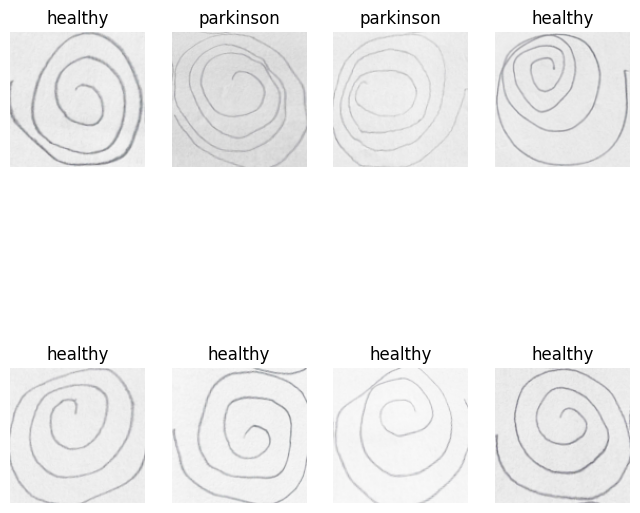

In [12]:
# Define paths directly to training and testing subdirectories for spiral
spiral_train_path = spiral_path / 'training'
spiral_test_path = spiral_path / 'testing'

# Load and prepare spiral data using ImageDataLoaders with specific paths
spiral_data = ImageDataLoaders.from_folder(
    spiral_train_path.parent,
    train="training",
    valid="testing",
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(),
    bs=8
)

# Display a sample batch from the spiral dataset
spiral_data.show_batch(figsize=(8,8))



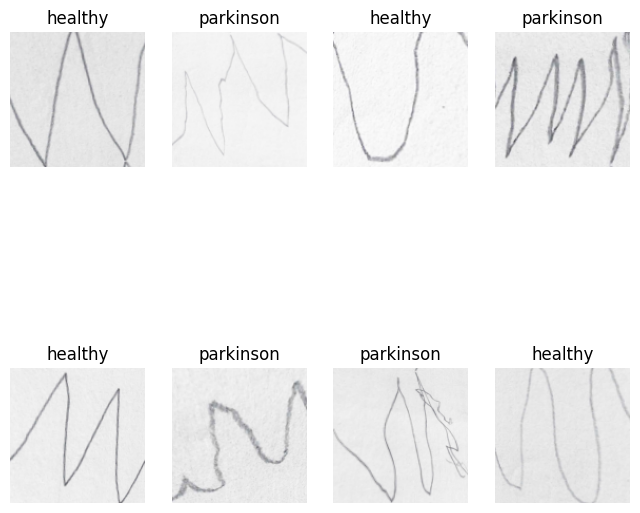

In [13]:
# Define paths directly to training and testing subdirectories for wave
wave_train_path = wave_path / 'training'
wave_test_path = wave_path / 'testing'

# Load and prepare wave data using ImageDataLoaders with specific paths
wave_data = ImageDataLoaders.from_folder(
    wave_train_path.parent,
    train="training",
    valid="testing",
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(),
    bs=8
)

# Display a sample batch from the wave dataset
wave_data.show_batch(figsize=(8,8))



epoch,train_loss,valid_loss,accuracy,time
0,1.190845,0.624671,0.700000,00:01
1,0.967884,0.833290,0.733333,00:01
2,0.943430,1.193825,0.700000,00:01
3,0.851191,1.265409,0.733333,00:01
4,0.852108,1.025683,0.800000,00:01


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

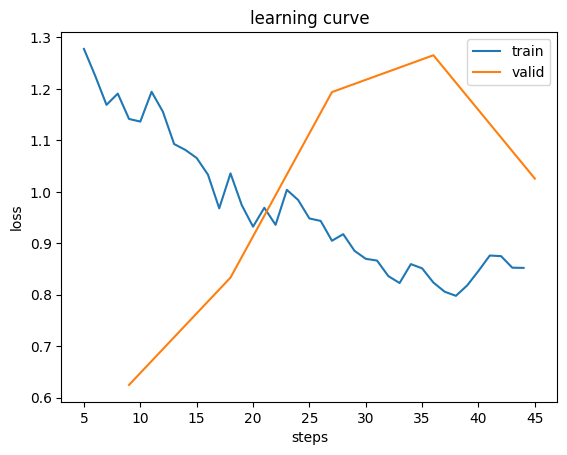

In [16]:
# Initialize and train model on spiral data
spiral_learn = cnn_learner(spiral_data, resnet34, metrics=accuracy).to_fp16()
spiral_learn.fit_one_cycle(5)

# Plot losses using the recorder
spiral_learn.recorder.plot_loss()


epoch,train_loss,valid_loss,accuracy,time
0,1.287274,0.813781,0.533333,00:13
1,1.053871,0.582626,0.700000,00:01
2,0.922776,0.611629,0.700000,00:01
3,0.992137,0.686262,0.700000,00:01
4,1.035013,0.801695,0.600000,00:01


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

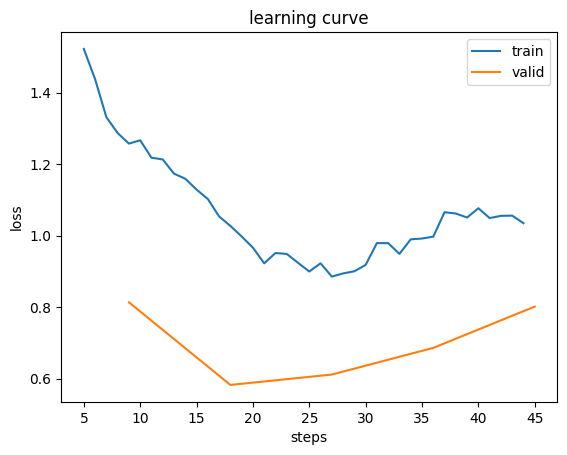

In [17]:
# Initialize and train model on wave data
wave_learn = cnn_learner(wave_data, resnet34, metrics=accuracy).to_fp16()
wave_learn.fit_one_cycle(5)

# Plot losses using the recorder
wave_learn.recorder.plot_loss()


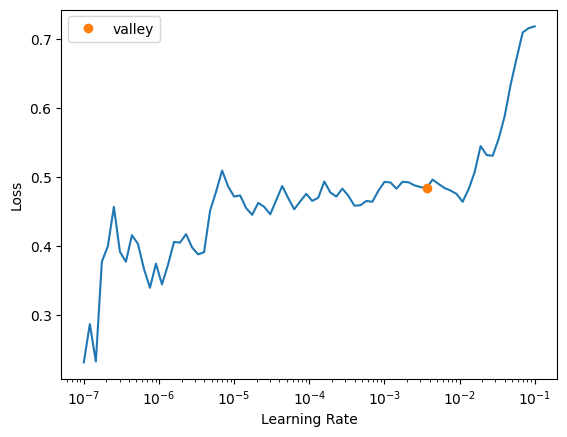

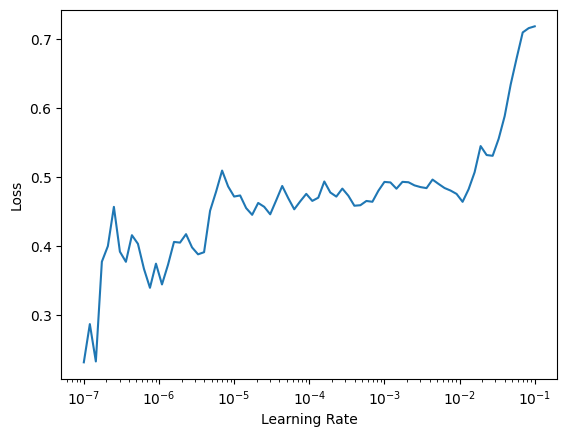

In [19]:
# Learning rate finder for spiral model
spiral_learn.lr_find()
spiral_learn.recorder.plot_lr_find()


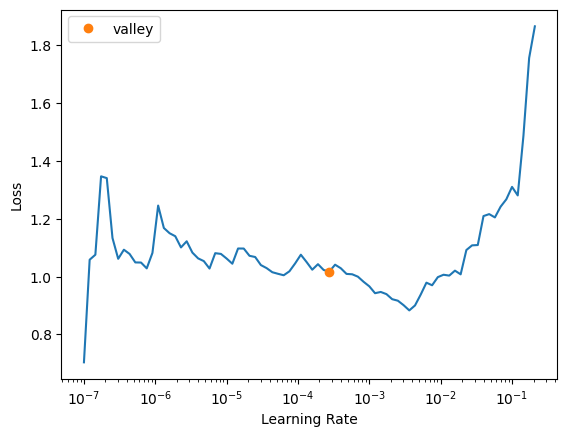

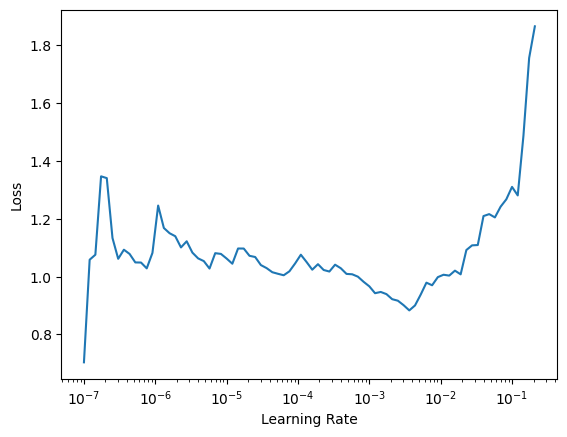

In [20]:
# Learning rate finder for wave model
wave_learn.lr_find()
wave_learn.recorder.plot_lr_find()


In [22]:
# Unfreeze and train the spiral model with a specific learning rate
spiral_learn.unfreeze()
spiral_learn.fit_one_cycle(5, lr_max=1e-04)


epoch,train_loss,valid_loss,accuracy,time
0,0.795919,0.842763,0.766667,00:01
1,0.676288,0.634052,0.800000,00:01
2,0.658215,0.684323,0.800000,00:02
3,0.652502,0.815047,0.766667,00:02
4,0.661804,0.827278,0.766667,00:01


In [23]:
# Unfreeze and train the wave model with a specific learning rate
wave_learn.unfreeze()
wave_learn.fit_one_cycle(5, lr_max=1e-04)


epoch,train_loss,valid_loss,accuracy,time
0,0.708886,0.720737,0.666667,00:02
1,0.861112,0.702547,0.666667,00:02
2,0.902395,0.584312,0.800000,00:01
3,0.981985,0.540182,0.800000,00:01
4,0.855488,0.627925,0.800000,00:01


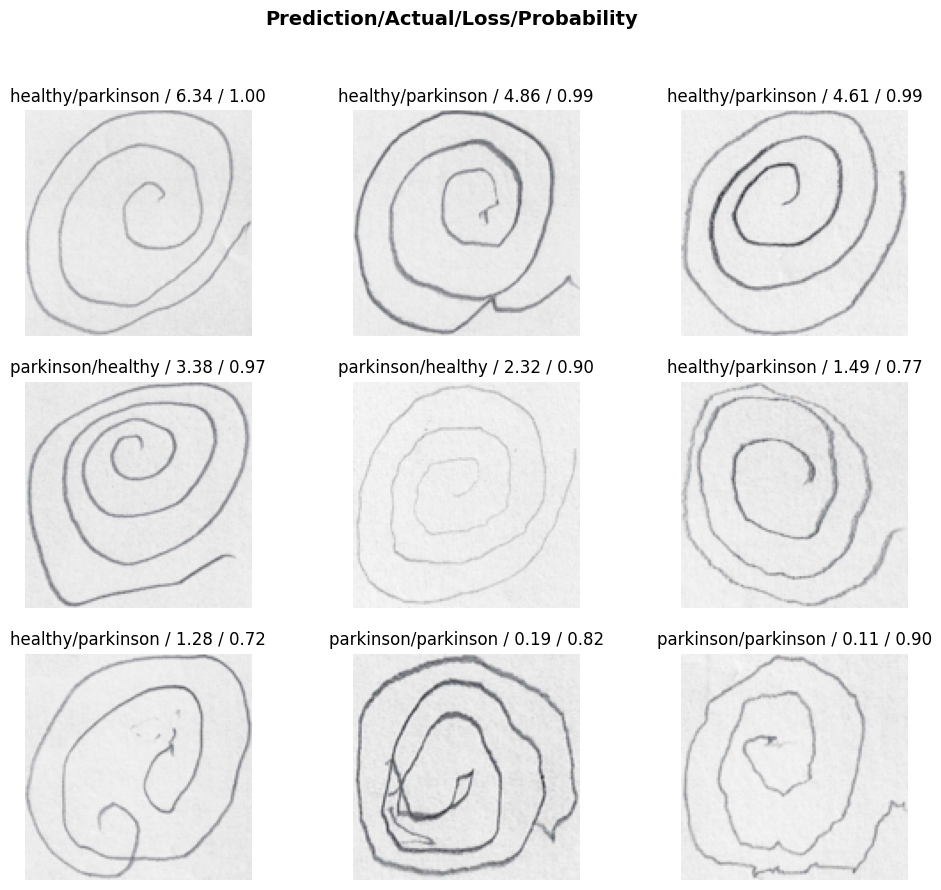

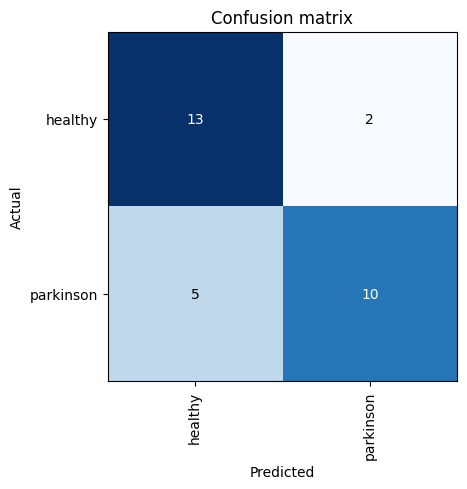

In [25]:
# Save spiral model
spiral_learn.save('spiral-stage-1-rn34')

# Interpret spiral model results
spiral_interp = ClassificationInterpretation.from_learner(spiral_learn)
spiral_interp.plot_top_losses(9, figsize=(12,10))  # Removed heatmap argument
spiral_interp.plot_confusion_matrix()


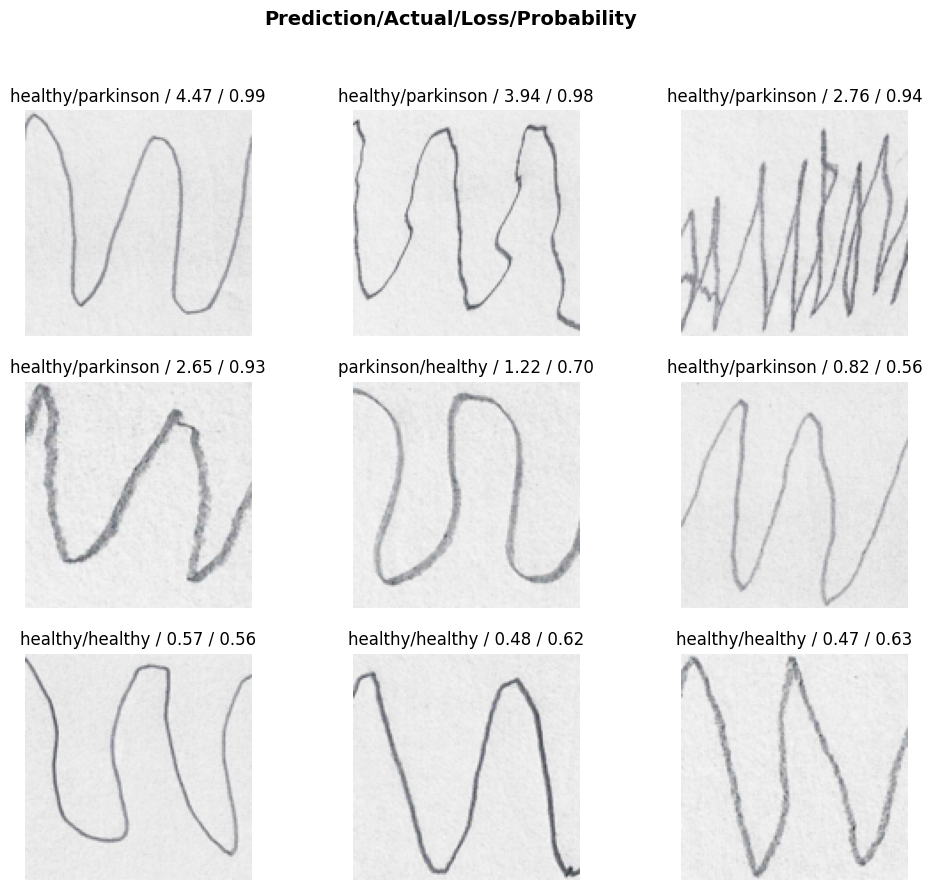

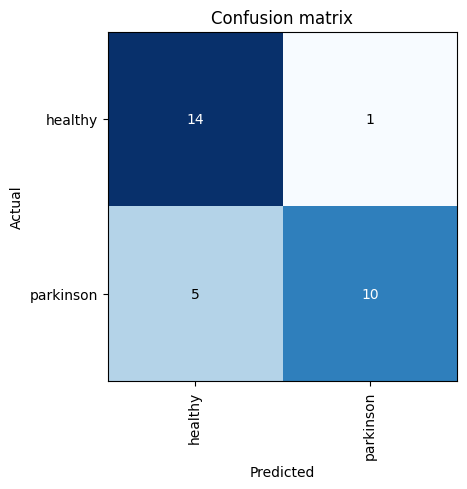

In [26]:
# Save wave model
wave_learn.save('wave-stage-1-rn34')

# Interpret wave model results
wave_interp = ClassificationInterpretation.from_learner(wave_learn)
wave_interp.plot_top_losses(9, figsize=(12,10))  # Removed heatmap argument
wave_interp.plot_confusion_matrix()


In [27]:
# Reload spiral data with 256x256 images
spiral_data = ImageDataLoaders.from_folder(
    spiral_train_path.parent,
    train="training",
    valid="testing",
    item_tfms=Resize(256),
    batch_tfms=aug_transforms(),
    bs=8
)

# Initialize and train the spiral model again
spiral_learn = cnn_learner(spiral_data, resnet34, metrics=accuracy).to_fp16()
spiral_learn.load('spiral-stage-1-rn34')  # Load previous weights
spiral_learn.fit_one_cycle(5)


epoch,train_loss,valid_loss,accuracy,time
0,0.993100,0.752030,0.766667,00:01
1,0.757571,0.794644,0.700000,00:01
2,0.725622,0.870075,0.766667,00:01
3,0.731371,0.915561,0.766667,00:01
4,0.673951,0.880785,0.766667,00:01


In [28]:
# Reload wave data with 256x256 images
wave_data = ImageDataLoaders.from_folder(
    wave_train_path.parent,
    train="training",
    valid="testing",
    item_tfms=Resize(256),
    batch_tfms=aug_transforms(),
    bs=8
)

# Initialize and train the wave model again
wave_learn = cnn_learner(wave_data, resnet34, metrics=accuracy).to_fp16()
wave_learn.load('wave-stage-1-rn34')  # Load previous weights
wave_learn.fit_one_cycle(5)


epoch,train_loss,valid_loss,accuracy,time
0,1.250897,0.758417,0.666667,00:02
1,0.981950,0.498513,0.866667,00:01
2,0.926307,0.530792,0.766667,00:01
3,0.882343,0.527165,0.766667,00:01
4,0.744028,0.493808,0.800000,00:01


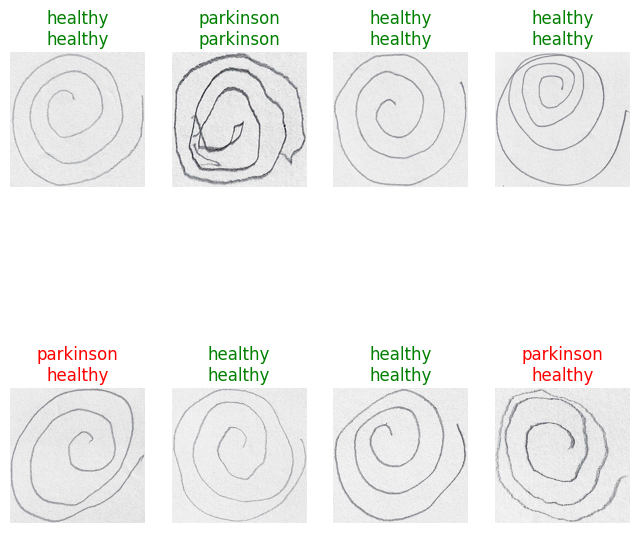

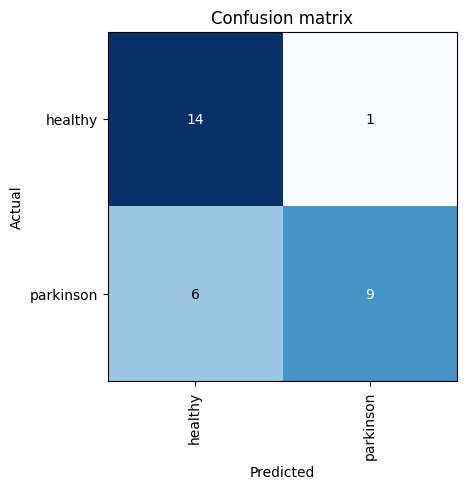

In [29]:
# Final evaluation of spiral model
spiral_learn.show_results(figsize=(8,8))
spiral_interp = ClassificationInterpretation.from_learner(spiral_learn)
spiral_interp.plot_confusion_matrix()

# Save the final spiral model
spiral_learn.save('spiral-stage-2-rn34-256-final')
spiral_learn.export('spiral-parkinson-predictor.pkl')


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


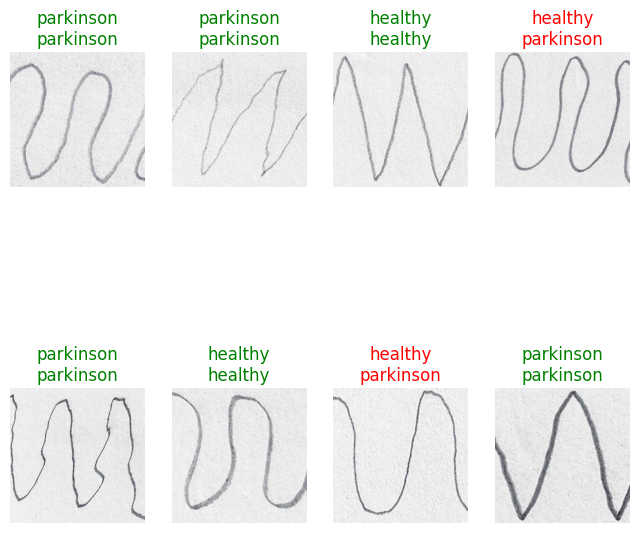

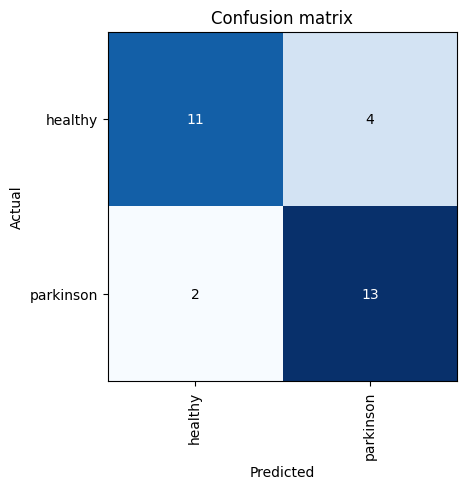

In [30]:
# Final evaluation of wave model
wave_learn.show_results(figsize=(8,8))
wave_interp = ClassificationInterpretation.from_learner(wave_learn)
wave_interp.plot_confusion_matrix()

# Save the final wave model
wave_learn.save('wave-stage-2-rn34-256-final')
wave_learn.export('wave-parkinson-predictor.pkl')


In [31]:
from sklearn.metrics import classification_report, accuracy_score

# Get predictions and true labels for spiral model
spiral_preds, spiral_targets = spiral_learn.get_preds()
spiral_pred_labels = spiral_preds.argmax(dim=1)  # Convert probabilities to class labels

# Get predictions and true labels for wave model
wave_preds, wave_targets = wave_learn.get_preds()
wave_pred_labels = wave_preds.argmax(dim=1)  # Convert probabilities to class labels


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


In [32]:
# Generate classification report for spiral model
print("Spiral Model Classification Report:")
print(classification_report(spiral_targets, spiral_pred_labels, target_names=spiral_data.vocab))

# Calculate accuracy separately
spiral_accuracy = accuracy_score(spiral_targets, spiral_pred_labels)
print(f"Spiral Model Accuracy: {spiral_accuracy * 100:.2f}%")


Spiral Model Classification Report:
              precision    recall  f1-score   support

     healthy       0.70      0.93      0.80        15
   parkinson       0.90      0.60      0.72        15

    accuracy                           0.77        30
   macro avg       0.80      0.77      0.76        30
weighted avg       0.80      0.77      0.76        30

Spiral Model Accuracy: 76.67%


In [33]:
# Generate classification report for wave model
print("Wave Model Classification Report:")
print(classification_report(wave_targets, wave_pred_labels, target_names=wave_data.vocab))

# Calculate accuracy separately
wave_accuracy = accuracy_score(wave_targets, wave_pred_labels)
print(f"Wave Model Accuracy: {wave_accuracy * 100:.2f}%")


Wave Model Classification Report:
              precision    recall  f1-score   support

     healthy       0.85      0.73      0.79        15
   parkinson       0.76      0.87      0.81        15

    accuracy                           0.80        30
   macro avg       0.81      0.80      0.80        30
weighted avg       0.81      0.80      0.80        30

Wave Model Accuracy: 80.00%
